# Introduction to Parallel Computing using Python

**Ningchuan Xiao**  
November 30, 2017

The goal of this workshop is to introduce some fundamental concepts of parallel computing. We focus on what we can do with Python, but in the meantime we will also discuss the computing environment. Two examples, kernel density estimation and a Monte Carlo simulation, will be used to demonstrate the pros and cons of parallel computing.

## Levels of parallelism

If we think about the two fundamental parts of computing, data and program, there are different ways we can separate them. Here is Flynn's taxonomy:

- SISD, Single instruction stream single data stream. A single processor executes a single data stream. This is the fundamental concept of von Neumann architecture. This is what we call a serial computer, where data is processed in sequentially. A single core on a PC is an example of this. My old machine with an Intel i486DX is also an example of this.
- SIMD, Single instruction, multiple data. Exactly the same instructions are executed at the same time by the processors, but the processors can work on different part of the data. It typically relies on an array of processors where the instruction is dispatched and an network for the processors to access the data. But again, the processors all run the same instruction at the same time. [Cray C90](https://en.wikipedia.org/wiki/Cray_C90) and IBM 9000 are the examples.
- MISD, Multiple instruction streams, single data stream. There are multiple instructions that work on the same data. There aren't too many examples of this on the market. However, we can think of multiple agents and they all try to compute something using the same data set. The data cannot be decomposed (hence single data stream), and there will be multiple results, each coming from one processor. Hardware wise, we don't have many examples of machines like this.
- MIMD, multiple instruction, multiple data. Most of today's parallel computers (including the multiple core PCs) use an MIMD architecture. 

To further understand parallel computing, we will also discuss the following important concepts:

- Critical section
- Multicore
- Shared memory
- Symmetric multiprocessing (SMP)
- Computer cluster
- Multithreading and parallelism
- Message passing and message passing interface (MPI)
- Embarrassingly parallel
- Speedup (also see [Amdahl's law](https://en.wikipedia.org/wiki/Amdahl%27s_law))


## Programming Paradigms

We focus on Python here and will discuss two particularly paradigms, multiprocessing that is suitable for SMP and scoop that is suitable for a clustered environment (and SMP as well).

### Installation

Installing **multiprocessing** is straightforward. If it is not already installed by default, use the following command to install it:

`pip3 install multiprocessing`

Installing **scoop**, however, will require more than just the Python part. For the Python part, though, we will need to use either pip or easy_install (because pip may not work for some cases).

`pip3 install scoop`

or

`easy_install-3.6 scoop`

In addition to installing the software, running scoop requires the use of **ssh** (secure shell), both the server and the client. For macOS, the ssh client is already installed by default and we only need to enable the server. To do so, go to Settings and click on Sharing. In the Sharing page, make sure Remote Login is checked on the left panel. 

For Windows machines, [putty](http://www.putty.org) is a commonly used client. The putty web page also contains links to [Bitvise SSH Client](https://www.bitvise.com/ssh-client-download) and [Bitvise SSH Server](https://www.bitvise.com/ssh-server-download). 

Before we do more computing tasks, let's take a look at our computing environment. To see the number of processors, we will have to import the multiprocessing module.

In [4]:
import platform
import multiprocessing as mp

print('Python      :', platform.python_version())
print('compiler    :', platform.python_compiler())
print('system      :', platform.system())
print('release     :', platform.release())
print('machine     :', platform.machine())
print('processor   :', platform.processor())
print('CPU count   :', mp.cpu_count())
print('Interpreter :', platform.architecture()[0])

Python      : 3.6.3
compiler    : GCC 4.2.1 (Apple Inc. build 5666) (dot 3)
system      : Darwin
release     : 17.2.0
machine     : x86_64
processor   : i386
CPU count   : 4
Interpreter : 64bit


## Hello World!

To utilize the multiple cores on this computer, we first take a look at the multiprocessing library of Python. This is especially good for a shared memory environment.

The multiprocessing module can be used in different ways and here we explore some of them. The first method is the Queue class. To retrieve the final result, it is necessary to use the `get` method of the Queue class at the end.

In [5]:
output = mp.Queue()

def worker(i, output):
    output.put('Hello World, from {}'.format(i))

processes = [mp.Process(target=worker, args=(x, output)) for x in range(20)]

for p in processes:
    p.start()

for p in processes:
    p.join()

results = [output.get() for p in processes]

for r in results:
    print(r)

Hello World, from 0
Hello World, from 1
Hello World, from 2
Hello World, from 3
Hello World, from 4
Hello World, from 5
Hello World, from 6
Hello World, from 7
Hello World, from 8
Hello World, from 9
Hello World, from 10
Hello World, from 11
Hello World, from 12
Hello World, from 13
Hello World, from 14
Hello World, from 15
Hello World, from 16
Hello World, from 17
Hello World, from 18
Hello World, from 19


The above process can be simplified using the `Manager` class of multiprocessing, which gives us a way to specify a list so that we can put results in that list. This is a special list because it will support concurrency (thus needs to be managed by a `Manager` object). A regular list may not be able to allow us to operate on it concurrently. 

In [6]:
manager = mp.Manager()
output2 = manager.list()

def worker(i, output):
    output.append('Hello World, from {}'.format(i))

processes = [mp.Process(target=worker, args=(x, output2)) for x in range(20)]

for p in processes:
    p.start()

for p in processes:
    p.join()

for r in output2:
    print(r)

Hello World, from 0
Hello World, from 1
Hello World, from 2
Hello World, from 3
Hello World, from 4
Hello World, from 5
Hello World, from 6
Hello World, from 8
Hello World, from 7
Hello World, from 9
Hello World, from 10
Hello World, from 11
Hello World, from 12
Hello World, from 13
Hello World, from 14
Hello World, from 15
Hello World, from 16
Hello World, from 17
Hello World, from 18
Hello World, from 19


Let's make some more useful examples:

In [8]:
import multiprocessing as mp
from math import pow

manager = mp.Manager()
output = manager.list()

def powered(x, out):
    out.append(int(pow(x, 4)))

processes = [mp.Process(target=powered, args=(x,output)) for x in range(20)]

for p in processes:
    p.start()

for p in processes:
    p.join()

print(output)

[0, 1, 16, 81, 256, 1296, 625, 2401, 4096, 6561, 10000, 14641, 20736, 28561, 38416, 50625, 83521, 65536, 130321, 104976]


### Pool class

The use of `Manager` and `Queue` classes are simple but not convenient. Also the order of the output can be somehow unexpected, because the processes may not finish in the order as we set them up. These processes are asynchronous. There is another class called Pool in multiprocessing that can be more convenient to use. This class extends two very useful functions in Python: [`apply`](https://docs.python.org/3.6/library/functions.html#apply) and [`map`](https://docs.python.org/3.6/library/functions.html#map) (note apply is for Python 2 only).

Here is a use of the Pool class using the apply method:

In [9]:
def worker(x):
    return int(pow(x, 4))

pool = mp.Pool(processes=4)
results = [pool.apply(worker, args=(x,)) for x in range(20)]
print(results)

[0, 1, 16, 81, 256, 625, 1296, 2401, 4096, 6561, 10000, 14641, 20736, 28561, 38416, 50625, 65536, 83521, 104976, 130321]


The map method does not need a for loop:

In [10]:
pool = mp.Pool(processes=4)
results = pool.map(worker, range(20))
print(results)

[0, 1, 16, 81, 256, 625, 1296, 2401, 4096, 6561, 10000, 14641, 20736, 28561, 38416, 50625, 65536, 83521, 104976, 130321]


These two methods, apply and map, block the function until it is done. This may cause delay because some function calls (recall we are in a concurrent environment) may finish sooner than others. Thus it is often more efficient to use the async versions of these methods. When this is the case, we must of the get method of the result to retrieve the results after the function is finished.

In [11]:
pool = mp.Pool(processes=4)
results = pool.map_async(worker, range(20))
print(results.get())

[0, 1, 16, 81, 256, 625, 1296, 2401, 4096, 6561, 10000, 14641, 20736, 28561, 38416, 50625, 65536, 83521, 104976, 130321]


![](rpicluster1.jpg)

## Hello from a cluster!

A computer cluster is different from SMP because there are multiple computers connected through a network to make a cluster. For this reason, it takes more to pass information to different computers, which is a critical part of parallel computing. There are different approaches proposed to address this issue. A commonly used one is called message passing interface (MPI). It should be noted that MPI is a standard, not a software system or library. This standard is implemented by different organization and agencies, mostly using C and C++. There are also higher level wrappers of MPI, including the very popular OpenMP. Outside C/C++, there are other language bindings, including Python, but they typically require the binary library to be installed, and installing such a framework may take a lot of work. Here, we are going to use [scoop](http://scoop.readthedocs.io/en/0.7/) to run code on a compute cluster. Writing the code may actually seem to be more straightforward than setting up the hardware. Here is the scoop version of Hello World:

```python
import os
import socket
from scoop import futures

def helloWorld(value):
    return "Hello World from Future #{0}, pid {1}, host {2}".format(value, os.getpid(), socket.gethostname())

if __name__ == "__main__":
    returnValues = list(futures.map(helloWorld, range(16)))
    print("\n".join(returnValues))
```

We run this program using 4 nodes on the same host like this:

```
python3 -m scoop -n 4 helloworld.py 
```

And here is the output from the run:

```
[2017-12-01 01:03:02,771] launcher  INFO    SCOOP 0.7 1.1 on darwin using Python 3.6.3 (v3.6.3:2c5fed86e0, Oct  3 2017, 00:32:08) [GCC 4.2.1 (Apple Inc. build 5666) (dot 3)], API: 1013
[2017-12-01 01:03:02,771] launcher  INFO    Deploying 4 worker(s) over 1 host(s).
[2017-12-01 01:03:02,771] launcher  INFO    Worker distribution: 
[2017-12-01 01:03:02,771] launcher  INFO       127.0.0.1:	3 + origin
Hello World from Future #0, pid 5645, host Ningchuans-MacBook-Pro.local
Hello World from Future #1, pid 5646, host Ningchuans-MacBook-Pro.local
Hello World from Future #2, pid 5645, host Ningchuans-MacBook-Pro.local
Hello World from Future #3, pid 5646, host Ningchuans-MacBook-Pro.local
Hello World from Future #4, pid 5645, host Ningchuans-MacBook-Pro.local
Hello World from Future #5, pid 5644, host Ningchuans-MacBook-Pro.local
Hello World from Future #6, pid 5646, host Ningchuans-MacBook-Pro.local
Hello World from Future #7, pid 5647, host Ningchuans-MacBook-Pro.local
Hello World from Future #8, pid 5645, host Ningchuans-MacBook-Pro.local
Hello World from Future #9, pid 5646, host Ningchuans-MacBook-Pro.local
Hello World from Future #10, pid 5647, host Ningchuans-MacBook-Pro.local
Hello World from Future #11, pid 5644, host Ningchuans-MacBook-Pro.local
Hello World from Future #12, pid 5645, host Ningchuans-MacBook-Pro.local
Hello World from Future #13, pid 5646, host Ningchuans-MacBook-Pro.local
Hello World from Future #14, pid 5645, host Ningchuans-MacBook-Pro.local
Hello World from Future #15, pid 5647, host Ningchuans-MacBook-Pro.local
[2017-12-01 01:03:03,800] launcher  (127.0.0.1:61988) INFO    Root process is done.
[2017-12-01 01:03:03,801] launcher  (127.0.0.1:61988) INFO    Finished cleaning spawned subprocesses.
```

To run this on multiple hosts, we need a host file that contains the addresses of the hosts (either IP addresses or host names). Here is what I have for the PI cluster:

```
pi@xpi0:~/work/scoop $ cat hostfile
xpi0
xpi1
xpi2
xpi3
```

And if we run the same code, 

```
$ python3 -m scoop -n 4 --hostfile hostfile helloworld.py
[2017-12-01 01:00:05,510] launcher  INFO    SCOOP 0.7 1.1 on linux using Python 3.4.2 (default, Oct 19 2014, 13:31:11) [GCC 4.9.1], API: 1013
[2017-12-01 01:00:05,510] launcher  INFO    Deploying 4 worker(s) over 4 host(s).
[2017-12-01 01:00:05,511] launcher  INFO    Worker distribution: 
[2017-12-01 01:00:05,511] launcher  INFO       xpi0:	0 + origin
[2017-12-01 01:00:05,511] launcher  INFO       xpi1:	1 
[2017-12-01 01:00:05,511] launcher  INFO       xpi2:	1 
[2017-12-01 01:00:05,512] launcher  INFO       xpi3:	1 
Hello World from Future #0, pid 1736, host xpi3
Hello World from Future #1, pid 1755, host xpi2
Hello World from Future #2, pid 1620, host xpi1
Hello World from Future #3, pid 1736, host xpi3
Hello World from Future #4, pid 1755, host xpi2
Hello World from Future #5, pid 1620, host xpi1
Hello World from Future #6, pid 1736, host xpi3
Hello World from Future #7, pid 1755, host xpi2
Hello World from Future #8, pid 1620, host xpi1
Hello World from Future #9, pid 1736, host xpi3
Hello World from Future #10, pid 1755, host xpi2
Hello World from Future #11, pid 1947, host xpi0
Hello World from Future #12, pid 1620, host xpi1
Hello World from Future #13, pid 1947, host xpi0
Hello World from Future #14, pid 1736, host xpi3
Hello World from Future #15, pid 1947, host xpi0
[2017-12-01 01:00:10,370] launcher  (127.0.0.1:40733) INFO    Root process is done.
[2017-11-13 05:48:38,396] __main__  INFO    Worker(s) launched using /bin/bash
[2017-11-13 05:48:34,338] __main__  INFO    Worker(s) launched using /bin/bash
[2017-11-13 05:48:35,073] __main__  INFO    Worker(s) launched using /bin/bash
[2017-12-01 01:00:11,764] launcher  (127.0.0.1:40733) INFO    Finished cleaning spawned subprocesses.
```

## Kernel density estimation

Kernel density estimation

$$
\widehat{f}_h(x) = \frac{1}{nh}\sum_{i=1}^n K\left(\frac{x-x_i}{h}\right)
$$

where $k$ is the kernel function that can take different forms. 

A uniform kernel function can be written as:

$$
K(u) = 1/2
$$

A Gaussian kernel function is

$$
K(u) = \sqrt{\frac{1}{2\pi}} e^{-\frac{1}{2}u^2}
$$

Here we define our own kdf functions:

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
import multiprocessing as mp

from sklearn.neighbors import KernelDensity
import timeit

In [2]:
def distance(x, y): 
    '''distance between two vectors'''
    return np.sqrt(np.sum((x-y)**2))

def kde_rect(data, x, h):
    '''
    Kernel density estimation, using rectangular kernel
    
    Input
        data   samples, a numpy array of D x n, D is the dimesion a data item
        x      a point of D dimensional data in a numpy array
               this is where the density is estimated
        h      bandwidh
        
    Output
        kernel density probability
    '''
    k = 0
    for p in data:
        u = distance(x.T, p)
        if u<h:
            k += 1/2
    return k/len(data)/h

def kde_gau(neighbors, x, h):
    '''
    Kernel density estimation, using Gaussian kernel
    '''
    k = 0
    for p in neighbors:
        u = distance(x.T, p)/h
        k += np.exp(-0.5*np.square(u))/np.sqrt(2*np.pi)
    return k/len(neighbors)/h

Below we compare (and validate) these functions with the example from the *Python Data Science Handbook* book where the author has a in-depth blog at [here](https://jakevdp.github.io/PythonDataScienceHandbook/05.13-kernel-density-estimation.html). This example starts with a function that can be used to make one-dimensional data set:

In [3]:
def make_data(N, f=0.3, rseed=1):
    rand = np.random.RandomState(rseed)
    x = rand.randn(N)
    x[int(f * N):] += 5
    return x

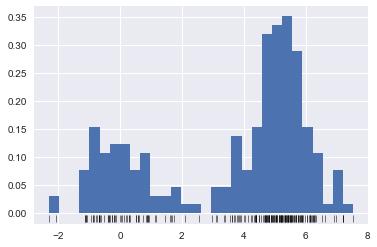

In [4]:
x = make_data(200)

ax = plt.gca()
ax.plot(x, np.full_like(x, -0.01), '|k', markeredgewidth=0.5)

plt.hist(x, bins=30, normed=True)
ax.set_ylim(-0.02, )
plt.show()

We want to estimate the density probability on these points:

In [5]:
x_d = np.linspace(-4, 8, 2000)

Now we use the kernel density estimation function in the sklean library to estimate:

In [6]:
# instantiate and fit the KDE model
kde = KernelDensity(bandwidth=1.0, kernel='tophat')
kde.fit(x[:, None]) # x[:, None] makes [x, x, ...] to [ [x], [x], ...]

# score_samples returns the log of the probability density
logprob = kde.score_samples(x_d[:, None])

Then we test our own functions to see if they produce the same results:

In [7]:
newest = [kde_rect(x, x_i, 1) for x_i in x_d]

It noticeable takes longer to finish. But the result is the same nonetheless (below). The performance is expected: we use list that is not supposed to be efficient though convenient.

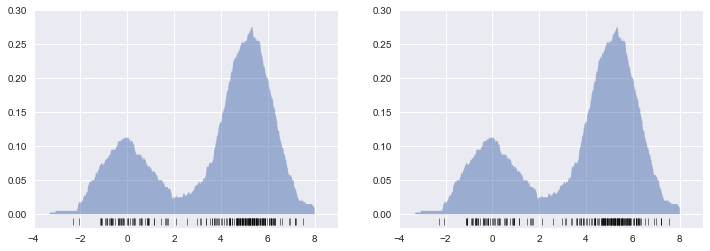

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4), 
                       subplot_kw={'xlim':(-4, 9), 'ylim':(-0.02, 0.3)})

ax[0].fill_between(x_d, np.exp(logprob), alpha=0.5)
ax[0].plot(x, np.full_like(x, -0.01), '|k', markeredgewidth=0.5)

ax[1].fill_between(x_d, newest, alpha=0.5)
ax[1].plot(x, np.full_like(x, -0.01), '|k', markeredgewidth=0.5)

plt.show()

Here is an example of using multidimensional data. This is a quick test and the data is from Raschka's blog at [here](http://sebastianraschka.com/Articles/2014_multiprocessing.html). Specifically, we can use a 3-D data set:

In [20]:
# samples within the cube
X_inside = np.array([[0,0,0],[0.2,0.2,0.2],[0.1, -0.1, -0.3]])

X_outside = np.array([[-1.2,0.3,-0.3],[0.8,-0.82,-0.9],[1, 0.6, -0.7],
                      [0.8,0.7,0.2],[0.7,-0.8,-0.45],[-0.3, 0.6, 0.9],
                      [0.7,-0.6,-0.8]])

point_x = np.array([[0],[0],[0]])
X_all = np.vstack((X_inside, X_outside))

kde_rect(X_all, point_x, 1)

0.15

Note the original blog has the result of 0.3, which is because they used a different kernel function that returns 1 (instead of 0.5) if x is within the bandwidth. The result from scilearn is also different.

In [21]:
kde = KernelDensity(bandwidth=1, kernel='tophat')
kde.fit(X_all)
np.exp(kde.score_samples(point_x.T))

array([ 0.07161972])

### Parallel kernel density estimation

We first, again, do a test to see if the parallel version works as same as the sequential version.

In [9]:
def kdeworker(x_i):
    return kde_rect(x, x_i, 1)

x_d = np.linspace(-4, 8, 2000)
pool = mp.Pool(processes=4)
results = pool.map_async(kdeworker, x_d)
output = results.get()


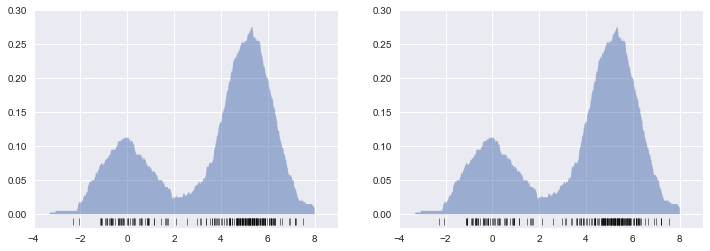

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4), 
                       subplot_kw={'xlim':(-4, 9), 'ylim':(-0.02, 0.3)})

ax[0].fill_between(x_d, output, alpha=0.5)
ax[0].plot(x, np.full_like(x, -0.01), '|k', markeredgewidth=0.5)

ax[1].fill_between(x_d, newest, alpha=0.5)
ax[1].plot(x, np.full_like(x, -0.01), '|k', markeredgewidth=0.5)

plt.show()

We want a good way to record running time. The timeit module is useful here. The following functions are used for testing.

In [11]:
def kdeworker(x_i):
    return kde_rect(x, x_i, 1)

def test_kde_parallel(numproc):
    pool = mp.Pool(processes=numproc)
    results = pool.map_async(kdeworker, x_d)
    output = results.get()
    
def test_kde_serial():
    return [kde_rect(x, x_i, 1) for x_i in x_d]

In [25]:
x_d = np.linspace(-4, 8, 1000)

timeit.Timer('test_kde_serial()',
            'from __main__ import test_kde_serial').timeit(number=1)

1.2821130689699203

In [26]:
numproc = 4
timeit.Timer('test_kde_parallel(numproc)',
            'from __main__ import test_kde_parallel, numproc').timeit(number=1)

0.7836477080127224

Now it seems everything works! Let's try more points and different processes.

In [27]:
x_d = np.linspace(-4, 8, 2000)
times = []

times.append(timeit.Timer('test_kde_serial()',
            'from __main__ import test_kde_serial').timeit(number=1))

processes = [1, 2, 3, 4, 5, 6]
for proc in processes:
    t = timeit.Timer('test_kde_parallel(proc)',
            'from __main__ import test_kde_parallel, proc').timeit(number=1)
    times.append(t)

In [28]:
times

[2.50549890199909,
 2.469709015043918,
 1.3715505849686451,
 1.3437778640072793,
 1.4246428109472618,
 1.4285255779977888,
 1.5169947510003112]

We also increase the number of points to be estimated to 10000. It should be noted that I had to restart the Python kernel and run only the necessary steps to make the following code functional, because the notebook reports "Too many open files" when it runs continuously to this point. 

In [12]:
x_d = np.linspace(-4, 8, 10000)

times = []

times.append(timeit.Timer('test_kde_serial()',
            'from __main__ import test_kde_serial').timeit(number=1))

processes = [1, 2, 3, 4, 5, 6]
for proc in processes:
    t = timeit.Timer('test_kde_parallel(proc)',
            'from __main__ import test_kde_parallel, proc').timeit(number=1)
    times.append(t)

In [13]:
times

[11.886058239964768,
 11.86131586204283,
 6.890743159048725,
 6.648359165992588,
 6.9483613290358335,
 7.1245807179948315,
 6.889364224974997]

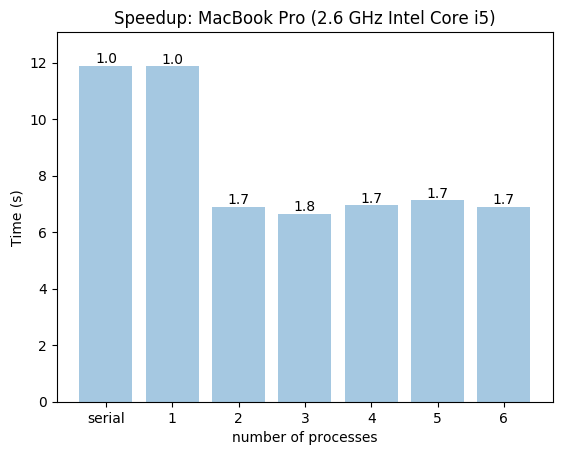

In [138]:
bar_labels = ['serial', '1', '2', '3', '4', '5', '6']

y_pos = np.arange(len(times))
bars = plt.bar(y_pos, times, align='center', alpha=0.4)

for ba, be in zip(bars, times):
    plt.text(ba.get_x()+ba.get_width()/2, ba.get_y() + ba.get_height(), 
            '{:.1f}'.format(times[0]/be),
            ha='center', va='bottom', fontsize=10)

plt.xticks(y_pos, bar_labels)
plt.ylabel('Time (s)')
plt.xlabel('number of processes')
plt.title('Speedup: MacBook Pro (2.6 GHz Intel Core i5)')
plt.ylim([0, max(times)*1.1])
plt.show()

The above is run on a MacBook Pro with a 2.6 GHz Intel Core i5. But the result may sound depressing! But I tried exactly the same code on a Linux machine with 8 cores:

```
Python      : 3.5.1
compiler    : GCC 6.1.1 20160621 (Red Hat 6.1.1-3)
system      : Linux
release     : 4.7.5-200.fc24.x86_64
machine     : x86_64
processor   : x86_64
CPU count   : 8
Interpreter : 64bit
```

We can't get more specific info about the CPU, but this is a Dell Workstation with 2 quad-core Xeon 2.8 GHz and here is the outcome for the number of processes ranging from 1 to 10:

`[29.00154008716345, 29.08831214904785, 14.774640083312988, 10.029979228973389, 7.395297527313232, 5.9974565505981445, 5.006225824356079, 4.2783331871032715, 3.8418874740600586, 4.013907432556152, 3.8412973880767822]`

These are actually great results and the plot shows it:

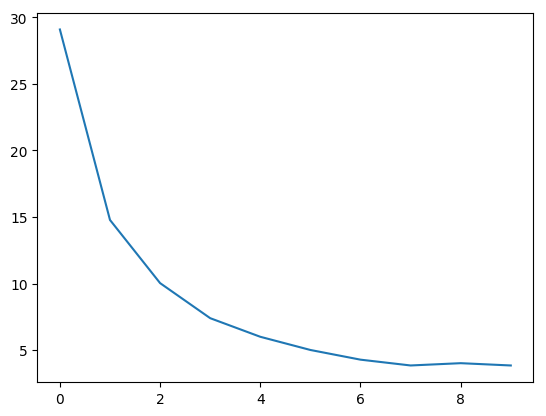

In [122]:
results = [29.00154008716345, 29.08831214904785, 14.774640083312988, 10.029979228973389, 7.395297527313232, 5.9974565505981445, 5.006225824356079, 4.2783331871032715, 3.8418874740600586, 4.013907432556152, 3.8412973880767822]

plt.plot(results[1:])
plt.show()

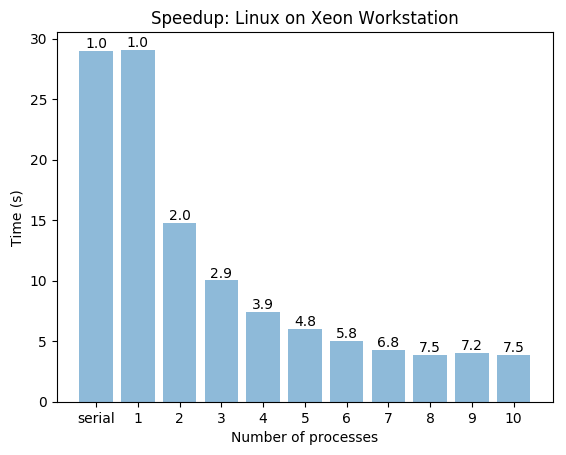

In [136]:
# plt.rcdefaults()

bar_labels = ['serial', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10']
y_pos = np.arange(len(results))
bars = plt.bar(y_pos, results, align='center', alpha=0.5)

for ba, be in zip(bars, results):
    plt.text(ba.get_x()+ba.get_width()/2, ba.get_y() + ba.get_height(), 
            '{:.1f}'.format(results[0]/be),
            ha='center', va='bottom', fontsize=10)

plt.xticks(y_pos, bar_labels)
plt.ylabel('Time (s)')
plt.xlabel('Number of processes')
plt.title('Speedup: Linux on Xeon Workstation')
plt.show()

The following is obtained using a [Raspberry PI 3 Model B](https://www.raspberrypi.org/products/raspberry-pi-3-model-b/) with a Quad Core 1.2GHz Broadcom BCM2837 64bit CPU.

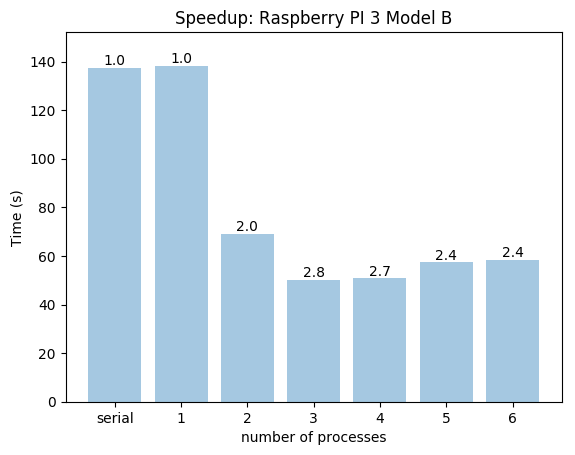

In [134]:
piresults = [137.48287486799973, 138.27194261550903, 69.1136245727539, 49.99051880836487, 50.78684687614441, 57.31438446044922, 58.498544454574585]
bar_labels = ['serial', '1', '2', '3', '4', '5', '6']

y_pos = np.arange(len(piresults))
bars = plt.bar(y_pos, piresults, align='center', alpha=0.4)

for ba, be in zip(bars, piresults):
    plt.text(ba.get_x()+ba.get_width()/2, ba.get_y() + ba.get_height(), 
            '{:.1f}'.format(piresults[0]/be),
            ha='center', va='bottom', fontsize=10)

plt.xticks(y_pos, bar_labels)
plt.ylabel('Time (s)')
plt.xlabel('number of processes')
plt.title('Speedup: Raspberry PI 3 Model B')
plt.ylim([0, max(piresults)*1.1])
plt.show()

## Parallel computing on a cluster

We cannot use scoop in a jupyter notebook because scoop needs to be run from a command line. But below is the code that we use to test:

```python
from scoop import futures
import numpy as np

def distance(x, y):
    '''distance between two vectors'''
    return np.sqrt(np.sum((x-y)**2))

def kde_rect(data, x, h):
    '''
    Kernel density estimation, using rectangular kernel

    Input
        data   samples, a numpy array of D x n, D is the dimesion a data item
        x      a point of D dimensional data in a numpy array
               this is where the density is estimated
        h      bandwidh

    Output
        kernel density probability
    '''
    k = 0
    for p in data:
        u = distance(x.T, p)
        if u<h:
            k += 1/2
    return k/len(data)/h

def kde_gau(neighbors, x, h):
    '''
    Kernel density estimation, using Gaussian kernel
    '''
    k = 0
    for p in neighbors:
        u = distance(x.T, p)/h
        k += np.exp(-0.5*np.square(u))/np.sqrt(2*np.pi)
    return k/len(neighbors)/h

# by default, we use the same random seed to get the same results
def make_data(N, f=0.3, rseed=1):
    rand = np.random.RandomState(rseed)
    x = rand.randn(N)
    x[int(f * N):] += 5
    return x

def kdeworker(x_i):
    return kde_rect(x, x_i, 1)

x = make_data(200)
x_d = np.linspace(-4, 8, 2000)

import pickle

if __name__ == "__main__":
    # returnValues = list(futures.map(helloWorld, range(16)))
    results = futures.map(kdeworker, x_d)
    # print(list(results))
    dump = { 'x_d': x_d, 'results': list(results)}
    pickle.dump(dump, open( 'kde_results_scoop.pickle', 'wb' ) )
    # dump = pickle.load(open('kde_results_scoop.pickle', 'rb'))
```

We can run this program in the command line:

`python3 -m scoop -n 8 --hostfile hostfile kde_scoop.py`


The above program saves the output to a pickle file. Pickle is a very useful python module and a quick tutorial can be found at [here](https://wiki.python.org/moin/UsingPickle). Now we get the results back and place it side by side with what we have got before for a comparison.

In [1]:
import pickle

In [2]:
dump = pickle.load(open('kde_results_scoop.pickle', 'rb'))
x_d = dump['x_d']
results = dump['results']

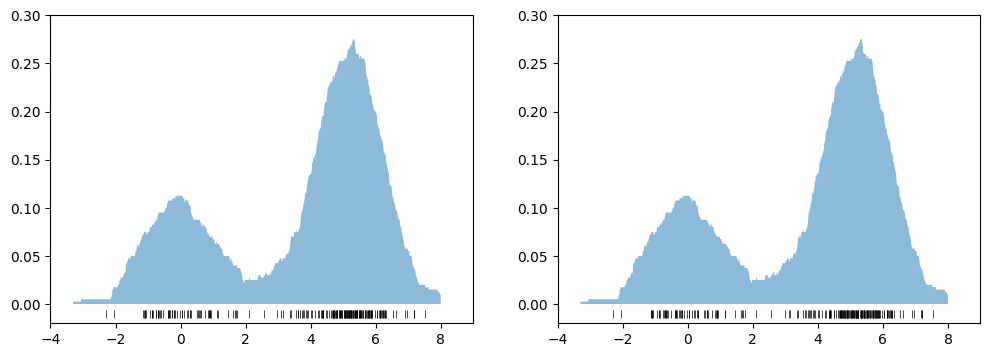

In [94]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4), 
                       subplot_kw={'xlim':(-4, 9), 'ylim':(-0.02, 0.3)})

ax[0].fill_between(x_d, results, alpha=0.5)
ax[0].plot(x, np.full_like(x, -0.01), '|k', markeredgewidth=0.5)

ax[1].fill_between(x_d, newest, alpha=0.5)
ax[1].plot(x, np.full_like(x, -0.01), '|k', markeredgewidth=0.5)

plt.show()

So it works on a computer cluster using scoop. 

We now test an embarrassingly parallel case of calculating the value of $\pi$ using a Monte Carlo approach. This is an example from the scoop documentation at [here](http://scoop.readthedocs.io/en/0.7/examples.html) and the code is listed below:

```python
# run it using python3 -m scoop -n 11 --hostfile hostfile get-pi.py 
# on local: python3 -m scoop -n 4 get-pi.py 
from math import hypot
from random import random
from scoop import futures
import time

def test(tries):
    return sum(hypot(random(), random()) < 1 for _ in range(tries))

def calcPi(nbFutures, tries):
    expr = futures.map(test, [tries] * nbFutures)
    return 4. * sum(expr) / float(nbFutures * tries)

if __name__ == "__main__":
    t1 = time.time()
    print("pi = {}".format(calcPi(3000, 5000)))
    t2 = time.time()
    print('time:', t2-t1)
```

This is run on the PI cluster using various settings:

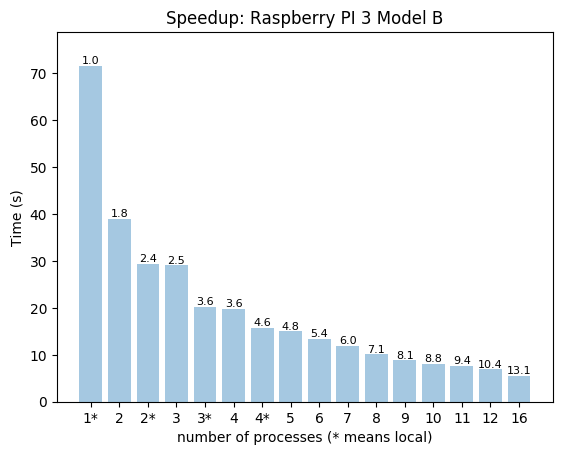

In [135]:
bar_labels = ['1*', '2', '2*', '3', '3*', '4', '4*', '5', '6', '7', '8', '9', '10', '11', '12', '16']
piresults = [71.65142703056335, 38.91786599159241, 29.40711545944214, 29.065842151641846, 20.15361213684082, 19.853610038757324, 15.730499029159546, 14.978558540344238, 13.375933408737183, 11.893508434295654, 10.091248512268066, 8.796955108642578, 8.110694646835327, 7.640932321548462, 6.89350152015686, 5.483535289764404]
y_pos = np.arange(len(piresults))
bars = plt.bar(y_pos, piresults, align='center', alpha=0.4)

for ba, be in zip(bars, piresults):
    plt.text(ba.get_x()+ba.get_width()/2, ba.get_y() + ba.get_height(), 
            '{:.1f}'.format(piresults[0]/be),
            ha='center', va='bottom', fontsize=8)

plt.xticks(y_pos, bar_labels)
plt.ylabel('Time (s)')
plt.xlabel('number of processes (* means local)')
plt.title('Speedup: Raspberry PI 3 Model B')
plt.ylim([0, max(piresults)*1.1])
plt.show()

## References

Materials presented in this notebook are adopted and extended from various online sources:

https://wiki.python.org/moin/ParallelProcessing

http://sebastianraschka.com/Articles/2014_multiprocessing.html

https://jakevdp.github.io/PythonDataScienceHandbook/05.13-kernel-density-estimation.html

http://scoop.readthedocs.io/en/0.7/examples.html